## Traitement de l'image pour détecter la grille et redresser le sudoku


In [131]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os
from datetime import datetime
import glob


In [132]:
# Ouvre la caméra 0 = caméra par défaut si on avait plusieurs caméras on a juste a changer le 0 par 1,2,3,...
video_capture = cv2.VideoCapture(0)
# Fixer le dossier d'enregistrement des captures
image_enregistre_dossier = r"c:\Image_save"

if not video_capture.isOpened():
    print("Erreur : Impossible d'ouvrir la caméra.")
    exit()

print("Caméra activée. Appuie sur 'q' pour quitter ou 'p' pour prendre une photo.")

while True:
    resultat, image_video = video_capture.read()
    if not resultat:
        print("Erreur lors de la lecture de la caméra.")
        break
# Affiche de la vidéo dans une fenêtre nommée Caméra_sudoku
    cv2.imshow("Caméra_sudoku", image_video)
# Attendre l'appuie de la toucgee 'q' pour quitter ou 'p' pour prendre une photo
    clavier = cv2.waitKey(1) & 0xFF

    if clavier == ord('q'):
        print("Caméra désactivée.")
        break

    if clavier == ord('p'):
    # année, mois, jour, heure, minute, seconde
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # enregistre l'image dans le dossier d'enregistrement
        nom_fichier = os.path.join(image_enregistre_dossier, f"sudoku_capture_{timestamp}.png")
    # permet d'éviter d'écraser les images
        cv2.imwrite(nom_fichier, image_video)

        # Vérifie si l'image a bien été enregistrée dans le dossier
        if os.path.exists(nom_fichier):
            print(f"Image enregistrée dans le dossier de test : {nom_fichier}")
        else:
            print("Échec de l'enregistrement.")
        

# Lorsqu'on arretera le script Python, il arretera la camera USB et fermera toutes les fenêtres d'apercu 
video_capture.release()
cv2.destroyAllWindows()
# Fin du script

Caméra activée. Appuie sur 'q' pour quitter ou 'p' pour prendre une photo.
Caméra désactivée.


Image la plus récente utilisée : c:\Image_save\sudoku_capture_2025-05-26_15-58-39.png


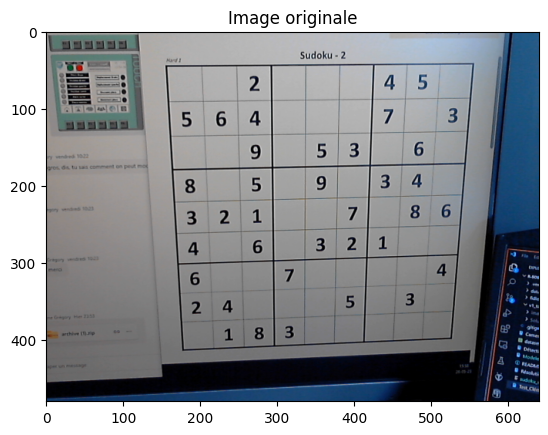

In [133]:

# Trouver le dernier fichier .png dans le dossier d'enregistrement
fichiers_png = glob.glob(os.path.join(image_enregistre_dossier, "*.png"))
dernier_fichier = max(fichiers_png, key=os.path.getctime) if fichiers_png else None

if dernier_fichier:
    image_path = dernier_fichier
    print(f"Image la plus récente utilisée : {image_path}")
else:
    print("Aucune image trouvée dans le dossier.")
    exit()
image = cv2.imread(image_path)
# Afficher l'image originale 
plt.figure()
plt.title("Image originale")
# Convertir l'image en RGB pour l'affichage avec matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


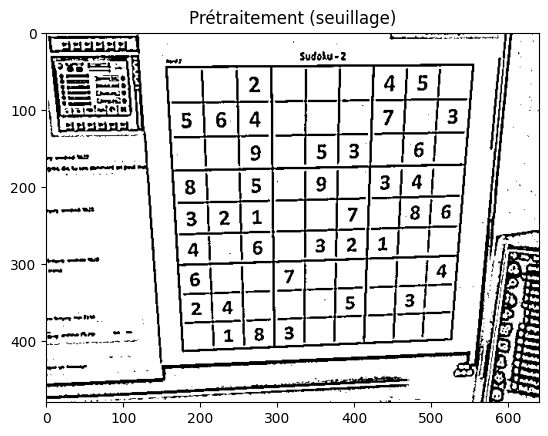

In [134]:
# Fonction de prétraitement de l'image
def pretraitement(image):
    # Convertit l'image en niveaux de gris pour simplifier le traitement.
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Réduit les petits bruits ou variations (comme les ombres ou pixels isolés).
    blur = cv2.GaussianBlur(gris, (3, 3), 6)
    #Transforme l’image floue en noir et blanc, pixel par pixel, en s’adaptant à la luminosité.
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

threshold = pretraitement(image)

plt.figure()
plt.title("Prétraitement (seuillage)")
plt.imshow(threshold, cmap='binary')
plt.show()


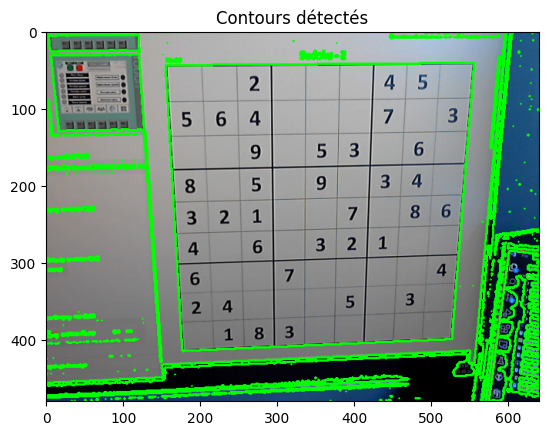

In [135]:
# On crée une copie de l’image couleur pour dessiner par-dessus sans modifier l’originale.
contour_debug = image.copy()
# Détection des contours dans l'image prétraitée.
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# On dessine les contours détectés sur la copie de l'image.
cv2.drawContours(contour_debug, contours, -1, (0, 255, 0), 2)

plt.figure()
plt.title("Contours détectés")
plt.imshow(cv2.cvtColor(contour_debug, cv2.COLOR_BGR2RGB))
plt.show()


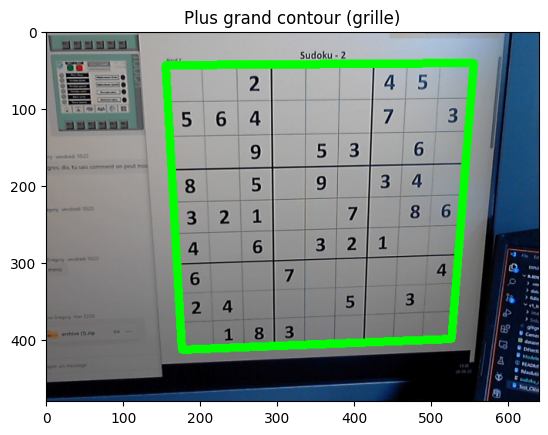

In [136]:

# Fonction pour trouver le plus grand contour qui ressemble à un quadrilatère (comme une grille de sudoku)
def trouver_plus_grand_contour(contours):
    # Stocker le plus grand contour trouvé
    biggest = None
    # mémorise le plus grand contour trouvé jusqu'ici
    max_area = 0
    # Parcourir tous les contours détectés
    for c in contours:
        area = cv2.contourArea(c)
        # On ne garde que les contours dont la surface est significative (plus de 100 pixels)
        if area > 100:
            perimètre = cv2.arcLength(c, True)
            # approx contiendra typiquement 4 points si c’est un rectangle/quadrilatère
            approx = cv2.approxPolyDP(c, 0.02 * perimètre, True)
            if area > max_area and len(approx) == 4:
                # On garde le contour s’il est plus grand que le précédent
                biggest = approx
                max_area = area
    return biggest
biggest = trouver_plus_grand_contour(contours)
contour_red = image.copy()

# Si un contour quadrilatère a été trouvé, on le dessine en vert sur l'image originale
if isinstance(biggest, np.ndarray) and biggest.shape[0] == 4:
    cv2.drawContours(contour_red, [biggest], -1, (0, 255, 0), 10)

    plt.figure()
    plt.title("Plus grand contour (grille)")
    # Convertir l'image en RGB pour l'affichage avec matplotlib
    plt.imshow(cv2.cvtColor(contour_red, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Aucun contour quadrilatère détecté")


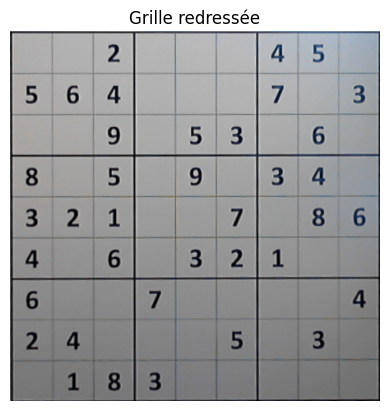

In [137]:
# Fonctione de réorganisation des points du quadrilatère pour les mettre dans l'ordre
def reorder(points):
    # On s'assure que les points sont dans un format approprié
    points = points.reshape((4, 2))
    # On crée un tableau pour les nouveaux points réordonnés
    points_new = np.zeros((4, 1, 2), dtype=np.int32)
    # Calcule la somme et la différence des coordonnées pour identifier les coins
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)] # Coin supérieur gauche
    points_new[3] = points[np.argmax(add)] # Coin inférieur droit
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)] # Coin supérieur droit
    points_new[2] = points[np.argmax(diff)] # Coin inférieur gauche
    return points_new

# Si on a trouvé un contour quadrilatère, on le réorganise pour la transformation perspective
if biggest is not None and len(biggest) == 4:
    biggest = reorder(biggest)
    pts1 = np.float32(biggest)
    # On définit les points de destination pour la transformation perspective
    pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
    # On crée la matrice de transformation perspective pour redresser la grille
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # On applique la transformation à l'image
    imagewrap = cv2.warpPerspective(image, matrix, (450, 450))
    # Convertir l'image redressée en RGB pour l'affichage
    imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.title("Grille redressée")
    plt.imshow(imagewrap)
    plt.axis('off')
    plt.show()
else:
    print("Grille non trouvée pour transformation")


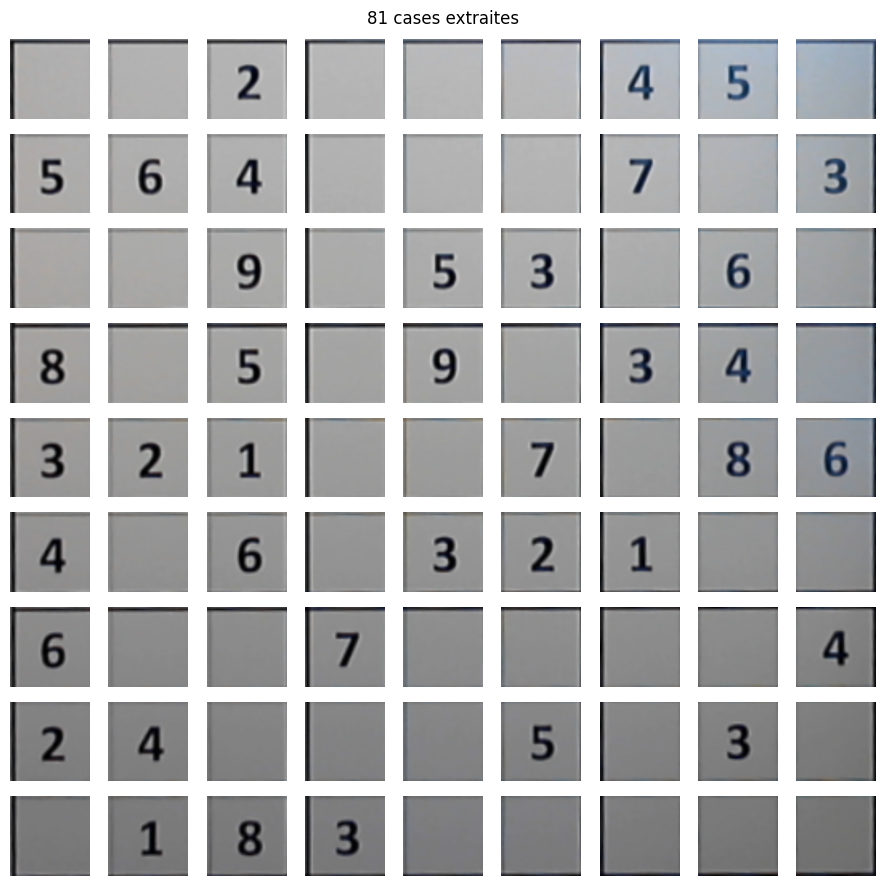

In [143]:
def decouper_grille_en_cases(grille_image):
    # Découpe une grille 450x450 en 81 images 50x50. 
    cases = []
    taille_case = grille_image.shape[0] // 9  # 450 // 9 = 50

    for y in range(9):
        for x in range(9):
            x1 = x * taille_case
            y1 = y * taille_case
            case = grille_image[y1:y1+taille_case, x1:x1+taille_case]
            case = cv2.resize(case, (128, 128))  # adapter à la taille d'entrée du CNN
            cases.append(case)
    return cases
cases = decouper_grille_en_cases(imagewrap)

# Affichage des 81 cases
plt.figure(figsize=(9, 9))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(cases[i], cmap='binary')
    plt.axis('off')
plt.suptitle("81 cases extraites")
plt.tight_layout()
plt.show()
# def decouper_grille_en_cases_blanches(grille_image, taille_case=50):
#     cases = []
#     grille_image = cv2.resize(grille_image, (450, 450))  # Assure-toi d’une taille parfaite

#     for y in range(9):
#         for x in range(9):
#             x1 = x * taille_case
#             y1 = y * taille_case
#             case = grille_image[y1:y1+taille_case, x1:x1+taille_case]

#             # Appliquer un masque adaptatif pour isoler le chiffre
#             gray = cv2.cvtColor(case, cv2.COLOR_BGR2GRAY)
#             thresh = cv2.adaptiveThreshold(gray, 255, 
#                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                            cv2.THRESH_BINARY_INV, 11, 2)

#             # Créer une image blanche et dessiner le chiffre en noir
#             fond_blanc = np.ones((taille_case, taille_case), dtype=np.uint8) * 255
#             fond_blanc[thresh > 0] = 0  # inversé pour que le chiffre soit noir

#             # Reconvertir en RGB pour le modèle
#             fond_rgb = cv2.cvtColor(fond_blanc, cv2.COLOR_GRAY2RGB)
#             cases.append(fond_rgb)

#     return cases
# cases = decouper_grille_en_cases_blanches(imagewrap)

# plt.figure(figsize=(9, 9))
# for i in range(81):
#     plt.subplot(9, 9, i + 1)
#     plt.imshow(cases[i], cmap='gray')
#     plt.axis('off')
# plt.suptitle("81 cases sur fond blanc")
# plt.tight_layout()
# plt.show()





In [139]:
def preprocess_case(case):
    gray = cv2.cvtColor(case, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11, 2
    )
    # Conversion en format (h, w, 1) et normalisation [0,1]
    thresh = thresh / 255.0
    return np.expand_dims(thresh, axis=-1)  # (56, 56, 1)

# 🔽 Fonction pour détecter si une case est vide
def est_vide(case):
    gray = cv2.cvtColor(case, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 3)
    return cv2.countNonZero(thresh) < 100  # seuil ajustable

# 🔽 Prédiction des chiffres
sudoku = []

for case in cases:
    # Resize à 128x128
    case_resized = cv2.resize(case, (128, 128))

    # Convertir en RGB si elle est en niveau de gris (très important !)
    if len(case_resized.shape) == 2 or case_resized.shape[2] == 1:
        case_rgb = cv2.cvtColor(case_resized, cv2.COLOR_GRAY2RGB)
    else:
        case_rgb = case_resized

    # Normalisation
    img = np.expand_dims(case_rgb, axis=0) / 255.0

    # Prédiction
    prediction = model.predict(img, verbose=0)
    digit = np.argmax(prediction)

    sudoku.append(digit)

# Affichage de la grille
sudoku = np.array(sudoku).reshape((9, 9))
print("Sudoku détecté :")
print(sudoku)


AttributeError: module 'pyexpat.model' has no attribute 'predict'